<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmarks" data-toc-modified-id="Benchmarks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Benchmarks</a></span><ul class="toc-item"><li><span><a href="#Fixed-Effects" data-toc-modified-id="Fixed-Effects-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fixed Effects</a></span></li><li><span><a href="#Random-Effects" data-toc-modified-id="Random-Effects-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Random Effects</a></span></li><li><span><a href="#Pooled-OLS" data-toc-modified-id="Pooled-OLS-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Pooled OLS</a></span></li><li><span><a href="#Only-LSTM" data-toc-modified-id="Only-LSTM-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Only LSTM</a></span></li></ul></li><li><span><a href="#Selected-Hybrid-Model" data-toc-modified-id="Selected-Hybrid-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Selected Hybrid Model</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison</a></span></li></ul></div>

In [88]:
# Importing libraries for analysis
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error,
    r2_score
)
from linearmodels.panel import RandomEffects
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from scipy.stats import randint

# Importing data preprocessing libraries
from sklearn.preprocessing import (
    MinMaxScaler, 
    LabelEncoder, 
    OneHotEncoder, 
    StandardScaler
)

# Importing libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as ticker

# Misc
import hashlib

In [89]:
#Adjusting display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 200)
sns.set_theme()

In [90]:
df_panel=pd.read_csv('Data/Panel Encoded.csv')

In [91]:
df_panel=df_panel.drop('Company ID', axis=1)

In [ ]:
train_list = []
val_list = []
test_list = []

company_names = df_panel['Company Name'].unique()

for company_name in company_names:
    company_data = df_panel[df_panel['Company Name'] == company_name]
    num_rows = company_data.shape[0]
    print(f"Company Name: {company_name}, Total Rows: {num_rows}")

    if num_rows > 2: 
        company_data = company_data.sort_values(by='Year')
        train_split_index = int(0.7 * num_rows)
        val_split_index = int(0.85 * num_rows)
        
        train_data = company_data.iloc[:train_split_index]
        val_data = company_data.iloc[train_split_index:val_split_index]
        test_data = company_data.iloc[val_split_index:]
        
        train_list.append(train_data)
        val_list.append(val_data)
        test_list.append(test_data)
    elif num_rows > 1:
        company_data = company_data.sort_values(by='Year')
        split_index = int(0.8 * num_rows)
        train_data = company_data.iloc[:split_index]
        test_data = company_data.iloc[split_index:]
        train_list.append(train_data)
        test_list.append(test_data)
    else:
        train_list.append(company_data)

train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)


In [93]:
df_panel.reset_index(inplace=True)
df_panel.set_index(['Company Name', 'Year'], inplace=True)

In [94]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.set_index(['Company Name', 'Year'], inplace=True)
val_df.set_index(['Company Name', 'Year'], inplace=True)
test_df.set_index(['Company Name', 'Year'], inplace=True)


In [95]:
from sklearn.compose import ColumnTransformer

scaler = MinMaxScaler(feature_range=(0, 1))
column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', scaler, ['Employment', 'GVA'])
    ],
    remainder='passthrough'
)


def prepare_lstm_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [96]:
# Assume 'GVA' as the target for LSTM
train_values = train_df['GVA'].values
print(f"Original train_values shape: {train_values.shape}")

# Reshape and scale
train_values_scaled = scaler.fit_transform(train_values.reshape(-1, 1))
print(f"Scaled train_values shape: {train_values_scaled.shape}")


Original train_values shape: (8835,)
Scaled train_values shape: (8835, 1)


In [97]:
# Prepare data for LSTM with 1 time step
time_steps = 1
X_train, y_train = prepare_lstm_data(train_values_scaled, time_steps)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (8834, 1, 1), y_train shape: (8834, 1)


In [98]:
# Prepare validation data for LSTM
val_values = val_df['GVA'].values
val_values_scaled = scaler.transform(val_values.reshape(-1, 1))
X_val, y_val = prepare_lstm_data(val_values_scaled, time_steps)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_val shape: (2353, 1, 1), y_val shape: (2353, 1)


# Benchmarks

## Fixed Effects

In [99]:
train_df_bench=train_df.copy()
test_df_bench=test_df.copy()

In [100]:
#Preparing data for fixed effects and fitting on fixed effects regression
train_df_bench['intercept'] = 1
train_exog_fe = train_df_bench[['intercept', 'Employment']]
train_endog_fe = train_df_bench['GVA']

fixed_effects_model = PanelOLS(train_endog_fe, train_exog_fe, entity_effects=True).fit()

# Predicting on test set
test_df_bench['intercept'] = 1
test_exog_fe = test_df_bench[['intercept', 'Employment']]
test_endog_fe = test_df_bench['GVA']
pred_fixed_effects = fixed_effects_model.predict(test_exog_fe)

if isinstance(pred_fixed_effects, pd.DataFrame):
    if pred_fixed_effects.shape[1] == 1:
        pred_fixed_effects = pred_fixed_effects.squeeze()
    else:
        raise ValueError("pred_fixed_effects DataFrame has more than one column")

test_endog_fe = pd.Series(test_endog_fe) if not isinstance(test_endog_fe, pd.Series) else test_endog_fe

fixed_effects_rmse = np.sqrt(((pred_fixed_effects - test_endog_fe) ** 2).mean())
fixed_effects_rmse


13414251.531603709

In [101]:
fixed_effects_mae = np.mean(np.abs(pred_fixed_effects - test_endog_fe))
fixed_effects_mae

813885.8821263014

In [102]:
fixed_effects_mape = mean_absolute_percentage_error(test_endog_fe, pred_fixed_effects)
fixed_effects_mape

5.010723097967475

## Random Effects

In [103]:
# Preparing data and fitting on random effects regression model
train_exog_re = train_df_bench[['Employment']]
train_endog_re = train_df_bench['GVA']

random_effects_model = RandomEffects(train_endog_re, train_exog_re).fit()

test_exog_re = test_df_bench[['Employment']]
test_endog_re = test_df_bench['GVA']
pred_random_effects = random_effects_model.predict(test_exog_re)

if isinstance(pred_random_effects, pd.DataFrame):
    if pred_random_effects.shape[1] == 1:
        pred_random_effects = pred_random_effects.squeeze()
    else:
        raise ValueError("pred_random_effects DataFrame has more than one column")

test_endog_re = pd.Series(test_endog_re) if not isinstance(test_endog_re, pd.Series) else test_endog_re

random_effects_rmse = np.sqrt(((pred_random_effects - test_endog_re) ** 2).mean())
print(f'Random Effects RMSE: {random_effects_rmse}')

random_effects_mae = np.mean(np.abs(pred_random_effects - test_endog_re))
print(f'Random Effects MAE: {random_effects_mae}')

random_effects_mape = mean_absolute_percentage_error(test_endog_re, pred_random_effects)
print(f'Random Effects MAPE: {random_effects_mape}')

Random Effects RMSE: 11852821.36551665
Random Effects MAE: 807376.2788966127
Random Effects MAPE: 3.4270926999006024


## Pooled OLS

In [104]:
# Prepare data for pooled OLS
train_exog_pool = train_df_bench[['intercept', 'Employment']]
train_endog_pool = train_df_bench['GVA']

test_df_bench['intercept'] = 1
test_exog_pool = test_df_bench[['intercept', 'Employment']]
test_endog_pool = test_df_bench['GVA']

In [105]:
# Fiting and predicting on the pooled OLS model
pooled_ols_model = sm.OLS(train_endog_pool, train_exog_pool).fit()

pred_pooled_ols = pooled_ols_model.predict(test_exog_pool)

pooled_ols_rmse = np.sqrt(((pred_pooled_ols - test_endog_pool) ** 2).mean())
print(f'Pooled OLS RMSE: {pooled_ols_rmse}')

pooled_ols_mae = np.mean(np.abs(pred_pooled_ols - test_endog_pool))
print(f'Pooled OLS MAE: {pooled_ols_mae}')

pooled_ols_mape = mean_absolute_percentage_error(test_endog_pool, pred_pooled_ols)
print(f'Pooled OLS MAPE: {pooled_ols_mape}')

Pooled OLS RMSE: 11695911.91840811
Pooled OLS MAE: 903572.839693663
Pooled OLS MAPE: 5.904937350693207


## Only LSTM

In [106]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
baseline=lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
277/277 [==============================] - 2s 3ms/step - loss: 2.5022e-04 - val_loss: 5.1963e-04
Epoch 2/30
277/277 [==============================] - 1s 2ms/step - loss: 2.3278e-04 - val_loss: 5.3225e-04
Epoch 3/30
277/277 [==============================] - 1s 2ms/step - loss: 2.1784e-04 - val_loss: 5.5300e-04
Epoch 4/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0460e-04 - val_loss: 5.6411e-04
Epoch 5/30
277/277 [==============================] - 1s 2ms/step - loss: 1.9661e-04 - val_loss: 5.8627e-04
Epoch 6/30
277/277 [==============================] - 1s 2ms/step - loss: 1.9073e-04 - val_loss: 6.0560e-04
Epoch 7/30
277/277 [==============================] - 1s 2ms/step - loss: 1.8635e-04 - val_loss: 6.2366e-04
Epoch 8/30
277/277 [==============================] - 1s 2ms/step - loss: 1.8418e-04 - val_loss: 6.3589e-04
Epoch 9/30
277/277 [==============================] - 1s 2ms/step - loss: 1.8162e-04 - val_loss: 6.4525e-04
Epoch 10/30
277/277 [=======

In [107]:
test_values = test_df['GVA'].values
test_values_scaled = scaler.transform(test_values.reshape(-1, 1))
X_test, y_test = prepare_lstm_data(test_values_scaled, time_steps)

In [108]:
test_predictions_lstm = lstm_model.predict(X_test)

122/122 [==============================] - 0s 1ms/step


In [109]:
test_predictions_lstm_inverse = scaler.inverse_transform(test_predictions_lstm)
y_test_inverse = scaler.inverse_transform(y_test)

actual_values = y_test_inverse.flatten()
predicted_values_lstm = test_predictions_lstm_inverse.flatten()

test_rmse = np.sqrt(mean_squared_error(actual_values, predicted_values_lstm))
test_mae = mean_absolute_error(actual_values, predicted_values_lstm)
test_mape = mean_absolute_percentage_error(actual_values, predicted_values_lstm)

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape}')

Test RMSE: 18464995.820962228
Test MAE: 1757169.91602306
Test MAPE: 13.614852045494555


# Selected Hybrid Model

In [110]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
277/277 [==============================] - 2s 3ms/step - loss: 2.5541e-04 - val_loss: 5.2078e-04
Epoch 2/30
277/277 [==============================] - 1s 2ms/step - loss: 2.2782e-04 - val_loss: 5.3209e-04
Epoch 3/30
277/277 [==============================] - 1s 2ms/step - loss: 2.1474e-04 - val_loss: 5.5133e-04
Epoch 4/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0307e-04 - val_loss: 5.6508e-04
Epoch 5/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0190e-04 - val_loss: 5.7490e-04
Epoch 6/30
277/277 [==============================] - 1s 2ms/step - loss: 1.9163e-04 - val_loss: 5.9664e-04
Epoch 7/30
277/277 [==============================] - 1s 2ms/step - loss: 1.9202e-04 - val_loss: 6.0657e-04
Epoch 8/30
277/277 [==============================] - 1s 2ms/step - loss: 1.7930e-04 - val_loss: 6.2187e-04
Epoch 9/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0247e-04 - val_loss: 6.3574e-04
Epoch 10/30
277/277 [=======

In [111]:
train_predictions = lstm_model.predict(X_train)
train_residuals = (y_train - train_predictions).flatten() 

277/277 [==============================] - 1s 1ms/step


In [112]:
X_train_rf = train_df.drop(columns=['GVA']).iloc[time_steps:].values
y_train_rf = train_residuals[:len(X_train_rf)]

print(f"X_train_rf shape: {X_train_rf.shape}")
print(f"y_train_rf shape: {y_train_rf.shape}")

X_train_rf shape: (8834, 5)
y_train_rf shape: (8834,)


In [113]:
rf_model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train_rf, y_train_rf.ravel())

best_params_random = random_search.best_params_

print(f"Best parameters from RandomizedSearchCV: {best_params_random}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from RandomizedSearchCV: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 79}


In [114]:
param_grid = {
    'n_estimators': [best_params_random['n_estimators'] - 10, best_params_random['n_estimators'], best_params_random['n_estimators'] + 10],
    'max_features': [best_params_random['max_features']],
    'max_depth': [None if best_params_random['max_depth'] is None else max(1, best_params_random['max_depth'] - 10), 
                  best_params_random['max_depth'], 
                  None if best_params_random['max_depth'] is None else best_params_random['max_depth'] + 10],
    'min_samples_split': [max(2, best_params_random['min_samples_split'] - 1), best_params_random['min_samples_split'], best_params_random['min_samples_split'] + 1],
    'min_samples_leaf': [max(1, best_params_random['min_samples_leaf'] - 1), best_params_random['min_samples_leaf'], best_params_random['min_samples_leaf'] + 1]
}

param_grid['min_samples_split'] = [max(2, x) for x in param_grid['min_samples_split']]
param_grid['min_samples_leaf'] = [max(1, x) for x in param_grid['min_samples_leaf']]

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train_rf, y_train_rf.ravel())

best_params_grid = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best parameters from GridSearchCV: {best_params_grid}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from GridSearchCV: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 79}


In [115]:
train_residuals_rf = best_rf_model.predict(X_train_rf)
train_final_predictions = train_predictions + train_residuals_rf.reshape(-1, 1)

In [116]:
test_values = test_df['GVA'].values
test_values_scaled = scaler.transform(test_values.reshape(-1, 1))
X_test, y_test = prepare_lstm_data(test_values_scaled, time_steps)


In [117]:
test_predictions_lstm = lstm_model.predict(X_test)

122/122 [==============================] - 0s 1ms/step


In [118]:
X_test_rf = test_df.iloc[time_steps:].drop(columns=['GVA']).values

In [119]:
test_residuals_rf = best_rf_model.predict(X_test_rf)

In [120]:
final_predictions = test_predictions_lstm + test_residuals_rf.reshape(-1, 1)

In [121]:
final_predictions[:5], y_test[:5]

(array([[ 0.0003265 ],
        [ 0.00058674],
        [-0.00085051],
        [ 0.00046271],
        [ 0.00039265]]),
 array([[0.00047587],
        [0.00061402],
        [0.00046504],
        [0.00052218],
        [0.00048461]]))

In [122]:
final_predictions_inverse = scaler.inverse_transform(final_predictions)
test_values_inverse = scaler.inverse_transform(test_values_scaled[:len(final_predictions)])

actual_values = test_values_inverse.flatten()
predicted_values_lstm = scaler.inverse_transform(test_predictions_lstm).flatten()
predicted_values_hybrid = final_predictions_inverse.flatten()

In [123]:
final_prediction_df = pd.DataFrame(final_predictions_inverse, columns =['Predicted GVA']) 

final_prediction_df

,Predicted GVA
0,-46327.494230
1,107243.149707
2,-740904.064008
3,34050.806616
4,-7290.241195
...,...
3878,-10041.998264
3879,39151.903992
3880,18732.600812
3881,32048.346360


In [124]:
actual_values_df = pd.DataFrame(test_values_inverse, columns =['Actual GVA']) 
comparison = final_prediction_df.join(actual_values_df)

In [125]:
comparison.head(10)

,Predicted GVA,Actual GVA
0,-46327.494230,93960.0
1,107243.149707,41818.0
2,-740904.064008,123347.0
3,34050.806616,35429.0
4,-7290.241195,69149.0
5,50681.801765,46980.0
6,163452.731774,58000.0
7,164402.111010,232000.0
8,-57467.195505,58000.0
9,116107.945908,42920.0


In [126]:
drop_2_cv_rmse_inv = np.sqrt(mean_squared_error(test_values_inverse, final_predictions_inverse))
print(f'Root Mean Squared Error on Test Set (Original Scale): {drop_2_cv_rmse_inv}')

drop_2_cv_mae_inv = mean_absolute_error(test_values_inverse, final_predictions_inverse)
print(f'Mean Absolute Error on Test Set (Original Scale): {drop_2_cv_mae_inv}')

drop_2_cv_r2_inv = r2_score(test_values_inverse, final_predictions_inverse)
print(f'R-squared on Test Set (Original Scale): {drop_2_cv_r2_inv}')

drop_2_cv_mape_inv = mean_absolute_percentage_error(test_values_inverse, final_predictions_inverse)
print(f'Mean Absolute Percentage Error on Test Set (Original Scale): {drop_2_cv_mape_inv}')

Root Mean Squared Error on Test Set (Original Scale): 7755817.49162979
Mean Absolute Error on Test Set (Original Scale): 900726.3218738543
R-squared on Test Set (Original Scale): 0.7554726286231748
Mean Absolute Percentage Error on Test Set (Original Scale): 8.258679148187612


In [127]:
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
train_final_predictions_original = scaler.inverse_transform(train_final_predictions).reshape(-1)

drop_2_cv_rmse_train_inv = np.sqrt(mean_squared_error(y_train_original, train_final_predictions_original))
print(f'Root Mean Squared Error on Train Set (Original Scale): {drop_2_cv_rmse_train_inv}')

drop_2_cv_mae_train_inv = mean_absolute_error(y_train_original, train_final_predictions_original)
print(f'Mean Absolute Error on Train Set (Original Scale): {drop_2_cv_mae_train_inv}')

drop_2_cv_r2_train_inv = r2_score(y_train_original, train_final_predictions_original)
print(f'R-squared on Train Set (Original Scale): {drop_2_cv_r2_train_inv}')


Root Mean Squared Error on Train Set (Original Scale): 5259863.25535184
Mean Absolute Error on Train Set (Original Scale): 539555.9379736669
R-squared on Train Set (Original Scale): 0.7125769284212423


# Comparison

In [128]:
metrics = {
    'Fixed Effects': {'RMSE': fixed_effects_rmse, 'MAE': fixed_effects_mae, 'MAPE': fixed_effects_mape},
    'Random Effects': {'RMSE': random_effects_rmse, 'MAE': random_effects_mae, 'MAPE': random_effects_mape},
    'Pooled OLS': {'RMSE': pooled_ols_rmse, 'MAE': pooled_ols_mae, 'MAPE': pooled_ols_mape},
    'Only LSTM': {'RMSE': test_rmse, 'MAE': test_mae, 'MAPE': test_mape},
    'Hybrid': {'RMSE': drop_2_cv_rmse_inv, 'MAE': drop_2_cv_mae_inv, 'MAPE': drop_2_cv_mape_inv}
}

/var/folders/47/9j3plv3x3gd1kzmxgfpmr6500000gn/T/ipykernel_1095/2681462436.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(models, rotation=45)
/var/folders/47/9j3plv3x3gd1kzmxgfpmr6500000gn/T/ipykernel_1095/2681462436.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(models, rotation=45)
/var/folders/47/9j3plv3x3gd1kzmxgfpmr6500000gn/T/ipykernel_1095/2681462436.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(models, rotation=45)


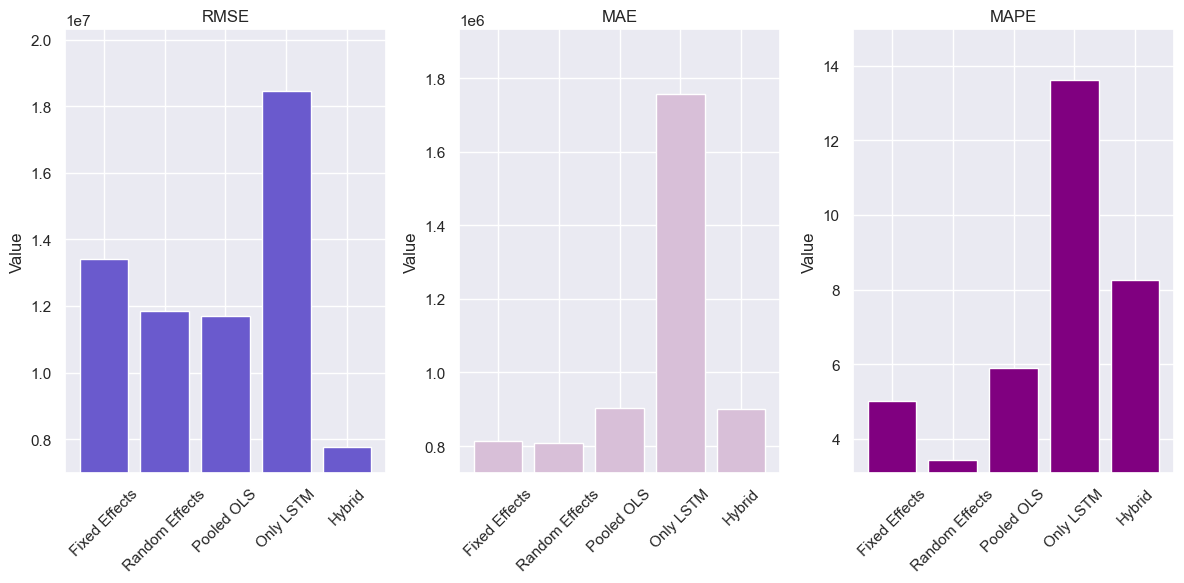

[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=70; total time=   0.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=153; total time=   1.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=179; total time=   1.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=107; total time=   1.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=122; total time=   0.9s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=139; total time=   0.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=103; total time=   0.8s
[CV] END max_depth=10, max_features=l

In [129]:
models = list(metrics.keys())
rmse_values = [metrics[model]['RMSE'] for model in models]
mae_values = [metrics[model]['MAE'] for model in models]
mape_values = [metrics[model]['MAPE'] for model in models]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].bar(models, rmse_values, color='slateblue')
ax[0].set_title('RMSE')
ax[0].set_ylabel('Value')
ax[0].set_ylim([min(rmse_values)*0.9, max(rmse_values)*1.1])
ax[0].set_xticklabels(models, rotation=45)

ax[1].bar(models, mae_values, color='thistle')
ax[1].set_title('MAE')
ax[1].set_ylabel('Value')
ax[1].set_ylim([min(mae_values)*0.9, max(mae_values)*1.1])
ax[1].set_xticklabels(models, rotation=45)

ax[2].bar(models, mape_values, color='purple')
ax[2].set_title('MAPE')
ax[2].set_ylabel('Value')
ax[2].set_ylim([min(mape_values)*0.9, max(mape_values)*1.1])
ax[2].set_xticklabels(models, rotation=45)

plt.tight_layout()
plt.show()